In [26]:
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from msresist.figures.figureM4 import predict_mutants
from msresist.clustering import PSPSLdict
import itertools
import numpy as np
from sklearn.manifold import MDS
from sklearn.decomposition import PCA

In [ ]:
with open('msresist/data/pickled_models/AXLmodel_PAM250_W2_5CL', 'rb') as p:
    model = pickle.load(p)[0]

## Multi-dimensional scaling 

In [27]:
pspls = list(PSPSLdict().values())
pssms = [np.delete(np.array(list(np.array(mat))), [5, 10], 1) for mat in model.pssms(PsP_background=True)]
mats = pspls + pssms

n = len(mats)
res = np.empty((n, n), dtype=float)
for ii, jj in itertools.permutations(np.arange(n), 2):
    res[ii, jj] = np.linalg.norm(mats[ii] - mats[jj])

res[res < 1.0e-100] = 0

mds = MDS(n_components=2, metric=False, dissimilarity="precomputed")
npos = mds.fit_transform(res)

clf = PCA(n_components=2)
npos = clf.fit_transform(npos)

table = pd.DataFrame()
table["Component 1"] = npos[:, 0]
table["Component 2"] = npos[:, 1]
table["Matrix Type"] = ["PSPL"] * len(pspls) + ["PSSM"] * model.ncl
table["Label"] = list(PSPSLdict().keys()) + list(np.arange(model.ncl) + 1)

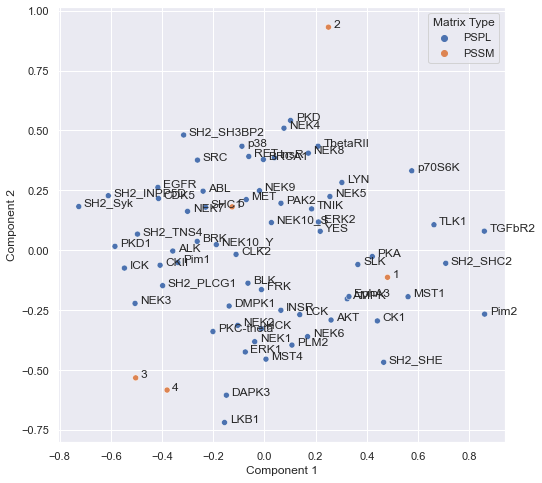

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
p = sns.scatterplot(x="Component 1", y="Component 2", data=table.set_index("Label"), hue="Matrix Type", ax=ax)

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))

label_point(table["Component 1"], table["Component 2"], table["Label"], p)

In [34]:
pssms = model.pssms(PsP_background=True)

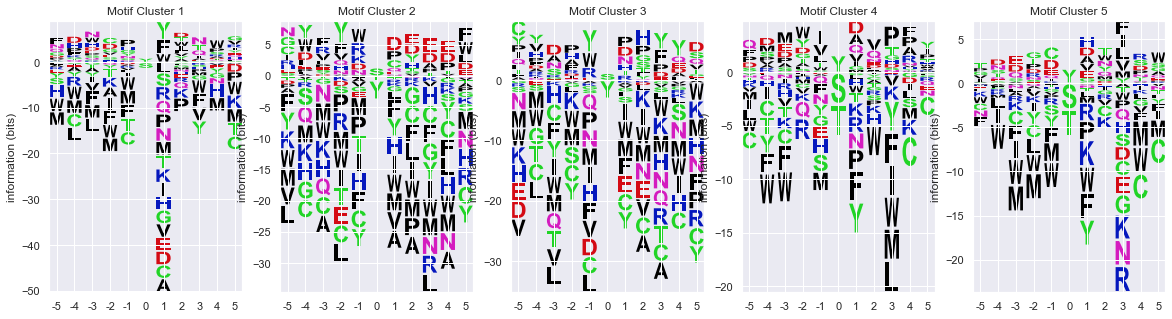

In [35]:
from msresist.figures.figure3 import plotMotifs

_, ax = plt.subplots(1, 5, figsize=(20, 5))
plotMotifs(pssms, [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5], axes=ax)

## Regression against methylation

In [158]:
mutations = pd.read_csv("msresist/data/MS/CPTAC/Patient_Mutations.csv").sort_values(by="Sample.ID").set_index("Sample.ID")
mtl = mutations["CIMP.status"]
mtl = mtl[~mtl.index.str.contains("IR")]

In [159]:
centers = pd.DataFrame(model.transform())
X = pd.read_csv("msresist/data/MS/CPTAC/CPTAC-preprocessedMotfis.csv").iloc[:, 1:]
centers["Patient_ID"] = X.columns[4:]
centers = centers.set_index("Patient_ID").sort_values(by="Patient_ID")
assert all(mtl.index == centers.index), "sampels not matching"

In [160]:
centers["drop"] = pd.isnull(mtl).values
centers = centers[centers["drop"] == False]

mtl = mtl.dropna().
assert all(centers.index == mtl.index), "samples not matching."